# Assignment 9
## Data driven predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

Importing the external files:


In [2]:
ExternalFilesFolder =  r"C:\Users\Gilberto\Desktop\poli\Energy building systems\Data-driven_Building_simulation_Polimi_EETBS\Data"
ConsumptionFileName= "consumption_5545.csv"
TemperatureFileName= "Austin_weather_2014.csv"
IrradianceFileName= "irradiance_2014_gen.csv"

path_consumptionFile = os.path.join(ExternalFilesFolder,ConsumptionFileName)
path_TemperatureFile = os.path.join(ExternalFilesFolder,TemperatureFileName)
path_IrradianceFile = os.path.join(ExternalFilesFolder,IrradianceFileName)

Reading the files and changing the indexes in order to have the possibility to use them as time datas:

In [3]:
DF_consumption = pd.read_csv(path_consumptionFile,sep=",", index_col=0)
DF_weather = pd.read_csv(path_TemperatureFile,sep=";",index_col=0)
DF_irradianceSource = pd.read_csv(path_IrradianceFile,sep=";",index_col=1)

PreviousIndex_c = DF_consumption.index
NewIndex_c= pd.to_datetime(PreviousIndex_c)
PreviousIndex_w = DF_weather.index
NewIndex_w= pd.to_datetime(PreviousIndex_w)
PreviousIndex_i = DF_irradianceSource.index
NewIndex_i= pd.to_datetime(PreviousIndex_i)

DF_consumption.index =NewIndex_c
DF_weather.index=NewIndex_w
DF_irradianceSource.index=NewIndex_i

Setting Data Frames for the needed datas: temperature, AC consumption and irradiance (wich is correlated to the PV generation):

In [4]:
DF_Temperature= DF_weather[["temperature"]]

DF_irradiance=DF_irradianceSource[["gen"]]
DF_irradiance[DF_irradiance["gen"]<0] = 0 #setting at zero all the negative datas

DF_consumption=DF_consumption

DF_joined = DF_consumption.join([DF_Temperature,DF_irradiance])
DF_joined.dropna(inplace=True)

C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(indexer, value)
C:\Users\Gilberto\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\pandas\core\frame.py:2326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

Creating a copy of my datas which will be modified for predictions, and shifting the temperature datas due to the different time zone of the measurements:

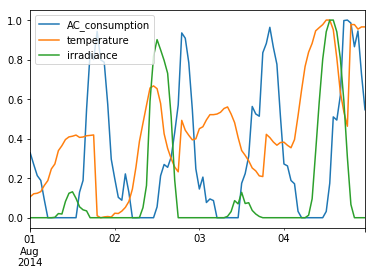

In [5]:
df_mod=DF_joined.copy()
df_mod.columns=["AC_consumption", "temperature","irradiance"]

df_mod["temperature"]=df_mod["temperature"].shift(-5)
df_mod.dropna(inplace=True)

#plotting a normalized version of my DF to see the qualitative behaviour:
df_mod_choosendates=df_mod["2014-08-01":"2014-08-04"]
df_mod_normalized_choosendates=(df_mod_choosendates-df_mod_choosendates.min())/(df_mod_choosendates.max()-df_mod_choosendates.min())
df_mod_normalized_choosendates.plot()
plt.show()

Creating lagged features and applying them to my dataframe in order to have meaningful datas for my predictions:

In [6]:

lag_start=1
lag_end=6
lag_interval=1
df=df_mod

def lagfeature(df, column_name, lag_start,lag_end,lag_interval):
    for i in range(lag_start, lag_end+1, lag_interval):
    
        new_column_name= column_name + "-"+ str(i)+"h"
        df[new_column_name]=df[column_name].shift(i)
        df.dropna(inplace=True)
    return df

df_mod= lagfeature(df_mod, "irradiance", 3,6,1)
df_mod= lagfeature(df_mod, "temperature", 1,6,1)
df_mod= lagfeature(df_mod, "AC_consumption", 1,24,1)
df_mod.head(24)

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-15h,AC_consumption-16h,AC_consumption-17h,AC_consumption-18h,AC_consumption-19h,AC_consumption-20h,AC_consumption-21h,AC_consumption-22h,AC_consumption-23h,AC_consumption-24h
2014-01-15 09:00:00,0.0,60.00,2.191083,0.000000,0.000000,0.000000,0.000000,58.34,57.37,53.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 10:00:00,0.0,62.22,3.120000,0.078900,0.000000,0.000000,0.000000,60.00,58.34,57.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 11:00:00,0.0,62.35,3.865200,0.862767,0.078900,0.000000,0.000000,62.22,60.00,58.34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 12:00:00,0.0,61.17,4.267967,2.191083,0.862767,0.078900,0.000000,62.35,62.22,60.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 13:00:00,0.0,56.35,4.310133,3.120000,2.191083,0.862767,0.078900,61.17,62.35,62.22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 14:00:00,0.0,50.09,3.985133,3.865200,3.120000,2.191083,0.862767,56.35,61.17,62.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 15:00:00,0.0,47.33,3.329083,4.267967,3.865200,3.120000,2.191083,50.09,56.35,61.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 16:00:00,0.0,45.24,2.062200,4.310133,4.267967,3.865200,3.120000,47.33,50.09,56.35,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 17:00:00,0.0,44.53,0.457383,3.985133,4.310133,4.267967,3.865200,45.24,47.33,50.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2014-01-15 18:00:00,0.0,44.41,0.000000,3.329083,3.985133,4.310133,4.267967,44.53,45.24,47.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's add time-related parameters extracted from the indexes converted before:

In [7]:
df_mod["hour"]=df_mod.index.hour
df_mod["day_of_week"]=df_mod.index.dayofweek
df_mod["week_of_year"]=df_mod.index.week
df_mod["month"]=df_mod.index.month

I need to correlate time and consumption, but time always restart from 0 while consumption values are continuous.
To avod this problem I convert "hour" into a radiant angle so it's possible to use sin and cos functions with it:

In [8]:
df_mod["sin_hour"]=np.sin(df_mod.index.hour*2*np.pi/24)
df_mod["cos_hour"]=np.cos(df_mod.index.hour*2*np.pi/24)
df_mod.head()

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-21h,AC_consumption-22h,AC_consumption-23h,AC_consumption-24h,hour,day_of_week,week_of_year,month,sin_hour,cos_hour
2014-01-15 09:00:00,0.0,60.00,2.191083,0.000000,0.000000,0.000000,0.0000,58.34,57.37,53.34,...,0.0,0.0,0.0,0.0,9,2,3,1,7.071068e-01,-0.707107
2014-01-15 10:00:00,0.0,62.22,3.120000,0.078900,0.000000,0.000000,0.0000,60.00,58.34,57.37,...,0.0,0.0,0.0,0.0,10,2,3,1,5.000000e-01,-0.866025
2014-01-15 11:00:00,0.0,62.35,3.865200,0.862767,0.078900,0.000000,0.0000,62.22,60.00,58.34,...,0.0,0.0,0.0,0.0,11,2,3,1,2.588190e-01,-0.965926
2014-01-15 12:00:00,0.0,61.17,4.267967,2.191083,0.862767,0.078900,0.0000,62.35,62.22,60.00,...,0.0,0.0,0.0,0.0,12,2,3,1,1.224647e-16,-1.000000
2014-01-15 13:00:00,0.0,56.35,4.310133,3.120000,2.191083,0.862767,0.0789,61.17,62.35,62.22,...,0.0,0.0,0.0,0.0,13,2,3,1,-2.588190e-01,-0.965926


Adding and applying other 2 features for improving my predictions:
WeekendDetector to know if the day is a working day or not, and DayDetector to set the working hours in a day :

In [9]:
def weekendDetector(day):
    if (day==5 or day==6):
        weekend=1
    else:
        weekend=0
    return weekend
    
df_mod["weekend"]=df_mod["day_of_week"].apply(weekendDetector)


def dayDetector(hour):
    if (hour<19 and hour>9):
        daylevel=1
    else:
        daylevel=0
    return daylevel
    
df_mod["working_time"]=df_mod["hour"].apply(dayDetector)

Finding correlations between each data:

In [10]:
df_mod.corr()

,AC_consumption,temperature,irradiance,irradiance-3h,irradiance-4h,irradiance-5h,irradiance-6h,temperature-1h,temperature-2h,temperature-3h,...,AC_consumption-23h,AC_consumption-24h,hour,day_of_week,week_of_year,month,sin_hour,cos_hour,weekend,working_time
AC_consumption,1.000000,0.162185,-0.052186,0.289370,0.387772,0.455629,0.484300,0.200637,0.244831,0.292178,...,0.849181,0.899897,0.359997,-0.014256,0.139440,0.128271,-0.437742,0.211137,-0.005530,-0.007603
temperature,0.162185,1.000000,0.363320,0.144172,0.069537,0.002721,-0.055473,0.983275,0.953316,0.913638,...,0.180408,0.141995,-0.001925,0.041830,0.119397,0.083509,0.079957,-0.344707,0.048517,0.207012
irradiance,-0.052186,0.363320,1.000000,0.558389,0.327221,0.102000,-0.095570,0.412619,0.439284,0.438400,...,0.050672,-0.056714,0.162862,-0.033186,-0.019419,-0.027600,-0.229510,-0.739696,-0.031778,0.762397
irradiance-3h,0.289370,0.144172,0.558389,1.000000,0.925267,0.767563,0.558353,0.222105,0.297827,0.363193,...,0.378133,0.282868,0.459734,-0.033227,-0.019555,-0.027738,-0.685470,-0.360428,-0.031829,0.609028
irradiance-4h,0.387772,0.069537,0.327221,0.925267,1.000000,0.925267,0.767563,0.144099,0.222050,0.297797,...,0.446541,0.378133,0.558296,-0.033257,-0.019553,-0.027737,-0.755460,-0.170631,-0.031850,0.434326
irradiance-5h,0.455629,0.002721,0.102000,0.767563,0.925267,1.000000,0.925267,0.069452,0.144031,0.222009,...,0.473616,0.446541,0.639377,-0.033565,-0.019496,-0.027673,-0.773923,0.030806,-0.032036,0.241848
irradiance-6h,0.484300,-0.055473,-0.095570,0.558353,0.767563,0.925267,1.000000,0.002624,0.069373,0.143980,...,0.459299,0.473616,0.669666,-0.033531,-0.019299,-0.027440,-0.739593,0.230157,-0.032704,0.047214
temperature-1h,0.200637,0.983275,0.412619,0.222105,0.144099,0.069452,0.002624,1.000000,0.983269,0.953296,...,0.224647,0.180361,0.056857,0.039445,0.119985,0.083375,-0.011990,-0.353388,0.047192,0.262170
temperature-2h,0.244831,0.953316,0.439284,0.297827,0.222050,0.144031,0.069373,0.983269,1.000000,0.983261,...,0.271322,0.224611,0.111053,0.037056,0.120585,0.083261,-0.103074,-0.337976,0.045954,0.301394
temperature-3h,0.292178,0.913638,0.438400,0.363193,0.297797,0.222009,0.143980,0.953296,0.983261,1.000000,...,0.318346,0.271303,0.159101,0.034679,0.121232,0.083228,-0.187104,-0.299480,0.044833,0.321822


In [11]:
DF_target= df_mod["AC_consumption"] 
DF_features= df_mod.drop("AC_consumption", axis=1)

# Part 2:
## Prediction models

From now on, let's use sklearn, which uses statistical methods to progressively improve algorithm's performances in identifying data patterns

In [12]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(DF_features,DF_target,test_size = 0.2, random_state=41234)

Fitting the model with the training datas:

In [13]:
from sklearn import linear_model

linear_reg = linear_model.LinearRegression()

linear_reg.fit(X_train, Y_train)
predicted_linearReg_split = linear_reg.predict(X_test)

predicted_DF_linearReg_split=pd.DataFrame(predicted_linearReg_split,index=Y_test.index, columns=["AC_cons_predicted_linearReg_split"])
predicted_DF_linearReg_split=predicted_DF_linearReg_split.join(Y_test)


Let's qualitatively see if it works

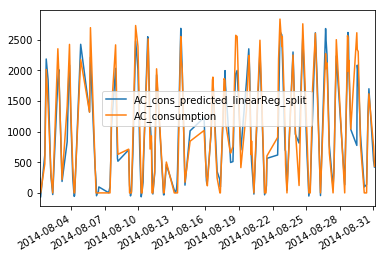

In [14]:
predicted_DF_linearReg_split_august=predicted_DF_linearReg_split["2014-08-01":"2014-08-31"]
predicted_DF_linearReg_split_august.plot()
plt.show(1)

Now let's see how accurate the predictions are:

In [15]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

MAE_linearReg_split= mean_absolute_error(predicted_linearReg_split,Y_test)
MSE_linearReg_split= mean_squared_error(predicted_linearReg_split,Y_test)
R2_linearReg_split = r2_score(predicted_linearReg_split,Y_test)

print ("R2 of the train test split is: " +str(R2_linearReg_split))


R2 of the train test split is: 0.878932135688


Using k-fold model instead of the splitting test one: 

In [16]:
from sklearn.model_selection import cross_val_predict

predict_linearReg_CV = cross_val_predict(linear_reg,DF_features,DF_target,cv=10)
predicted_DF_linearReg_CV=pd.DataFrame(predict_linearReg_CV, index=DF_target.index, columns=["AC_cons_predicted_linearReg_CV"])

predicted_DF_linearReg_CV=predicted_DF_linearReg_CV.join(DF_target)

Qualitative behaviour:

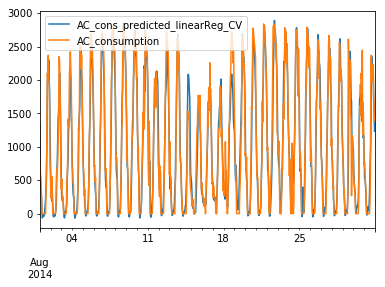

In [17]:
predicted_DF_linearReg_CV_august=predicted_DF_linearReg_CV["2014-08-01":"2014-08-31"]
predicted_DF_linearReg_CV_august.plot()
plt.show(1)

prediction's accuracy:

In [18]:
MAE_linearReg_CV= mean_absolute_error(predict_linearReg_CV,DF_target)
MSE_linearReg_CV= mean_squared_error(predict_linearReg_CV,DF_target)
R2_linearReg_CV = r2_score(predict_linearReg_CV,DF_target)

print ("R2 of the cross validation model is: " +str(R2_linearReg_CV))

R2 of the cross validation model is: 0.878041390785


Let's now use Random Forest algorithm:

In [19]:
from sklearn.ensemble import RandomForestRegressor

reg_RF = RandomForestRegressor() #jus to have a shorter name

predict_RF_CV = cross_val_predict(reg_RF,DF_features,DF_target,cv=10)

predicted_DF_RF_CV=pd.DataFrame(predict_RF_CV, index=DF_target.index, columns=["AC_cons_predicted_RF_CV"])
predicted_DF_RF_CV=predicted_DF_RF_CV.join(DF_target)

RF qualitative behaviour:

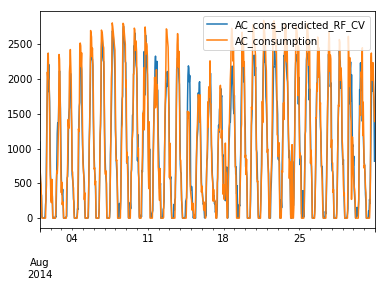

In [20]:
predicted_DF_RF_CV_august=predicted_DF_RF_CV["2014-08-01":"2014-08-31"]
predicted_DF_RF_CV_august.plot()
plt.show()

RF algoritmh's precision:

In [21]:
MAE_RF_CV= mean_absolute_error(predict_RF_CV,DF_target)
MSE_RF_CV= mean_squared_error(predict_RF_CV,DF_target)
R2_RF_CV = r2_score(predict_RF_CV,DF_target)

print ("R2 of the RF model is: " +str(R2_RF_CV))

R2 of the RF model is: 0.88487252641


Now, let's use Online learning to progressively improve algorithm's performances: 

In [22]:
DF_onlineConsumptionPrediction = pd.DataFrame(index=df_mod.index)

period_of_training = pd.Timedelta(30, unit="d")

FirstTimeStamp_measured = df_mod.index[0]
LastTimeStamp_measured = df_mod.index[-1]

FirstTimeStamp_toPredict= FirstTimeStamp_measured+period_of_training

training_startTimeStamp=FirstTimeStamp_measured
training_endTimeStamp=FirstTimeStamp_toPredict

timeStamp_toPredict= FirstTimeStamp_toPredict
DF_onlineConsumptionPrediction=DF_onlineConsumptionPrediction.truncate(before=training_endTimeStamp)

Setting online training:

In [23]:
while (timeStamp_toPredict< LastTimeStamp_measured):
    #print timeStamp_toPredict
    #DF_feature_train=DF_features.loc[training_startTimeStamp:training_endTimeStamp]
    DF_feature_train=DF_features.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    DF_target_train= DF_target.truncate(before=training_startTimeStamp,after=training_endTimeStamp)
    
    DF_feature_test = DF_features.loc[timeStamp_toPredict].values.reshape(1,-1) # If you dont add this it gives you an error, because you can not have a single line feature
    DF_target_test=DF_target.loc[timeStamp_toPredict]
    reg_RF.fit(DF_feature_train,DF_target_train) # Here I am just training with my training data
    predicted_Consumption = linear_reg.predict(DF_feature_test)
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Predicted"]=predicted_Consumption
    DF_onlineConsumptionPrediction.loc[timeStamp_toPredict,"Real"] = DF_target_test

    
    timeStamp_toPredict=timeStamp_toPredict+pd.Timedelta(1, unit="h")
    training_endTimeStamp=training_endTimeStamp+pd.Timedelta(1, unit="h")
    training_startTimeStamp=training_startTimeStamp + pd.Timedelta(1, unit="h")

DF_onlineConsumptionPrediction.dropna(inplace=True)

R2_score_online_linearReg = r2_score(DF_onlineConsumptionPrediction[["Real"]],
                                     DF_onlineConsumptionPrediction[["Predicted"]])

ValueError: shapes (1,88) and (44,) not aligned: 88 (dim 1) != 44 (dim 0)

In [ ]:
df_mod.index[1265]

In [24]:
df_mod.index[-1]

Timestamp('2014-12-31 00:00:00')